# Validation

We want to check whether our identification of face artifacts from street network polygons is correct. We postulate that, in accordance with our definitions:

1. **no** face artifacts contain buildings (with a possible small margin of error, e.g. there could be a bus stop tagged as "building" placed in the middle of a multilane street);
2. **some** urban blocks contain **no** buildings (e.g. squares, parks, sports and service areas).
For an automated validation of our findings, we can use building data from OSM to check statement 1:
Polygons classified as face artifacts, but which contain buildings, are wrongly classified and actually represent urban blocks (type 1 error). Note that an automated checking of statement 2 - i.e. actual face artifacts wrongly classified as urban blocks - is not possible since we have no ground truth (e.g. a list of "empty urban blocks") to test agains.

Thus, in this notebook we:
* download building data for all FUAs from OSM
* visually check FUA building data for sufficient completeness
* for the subset of FUAs with a sufficient completeness of building data on OSM,
    - import street network face polygons
    - classify them into face artifacts vs. urban blocks according to the face artifact threshold found for the FUA in Notebook 4 (peaks)
    - for each polygon, compute its area of intersection with the building data set
    - generate pseudo-confusion matrices for different tolerance thresholds (the threshold indicates how many square meters of building surface a face artifact is allowed contain without being classified as urban block)
    - visualize results of validation

In [19]:
## shapely 2.0.0.!
import shapely
from shapely import strtree
from shapely.geometry import LineString
from shapely.validation import make_valid

import os

os.environ["USE_PYGEOS"] = "0"
# import pygeos

import geopandas
import pandas
import dask_geopandas

import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

import os
import warnings

import json
from collections import Counter

from tqdm import tqdm

import osmnx as ox

**Import meta data**

In [7]:
# sample meta data
sample = geopandas.read_parquet("../data/sample.parquet")

**Download building data for each FUA from OSM**

In [ ]:
# TODO: for the last 3 cities (london, cologne, dortmund) - to run on HPC
sample.drop(sample[sample["eFUA_name"].isin(["London", "Cologne", "Dortmund"])].index, axis = 0, inplace = True)

In [ ]:
# Filter warnings about GeoParquet implementation.
warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")

for ix, row in tqdm(sample.iterrows(), total=len(sample)):
    city = row.eFUA_name

    # check if file exists - if it doesn't, download from OSM:
    if os.path.exists(f"../data/buildings/buildings_{city}.gpkg"):
        print(f"{city} building data already downloaded")
    elif os.path.exists(f"../data/buildings/buildings_{city}_clean.gpkg"):
        print(f"{city} building data already downloaded and preprocessed")
    else:
        print(f"dowloading {city} building data")
        # Download OSM buildings
        buildings = ox.geometries_from_polygon(
            sample[sample["eFUA_name"] == city].geometry.values[0],
            tags={"building": True},
        )
        buildings_small = buildings[["geometry"]]  # saving only most relevant columns
        buildings_small.to_file(f"../data/buildings/buildings_{city}.gpkg", index=False)
        del (buildings, buildings_small)
        print(f"{city} building data downloaded")

## Visual processing step in QGIS

In this step, for each FUA, we visually checked in QGIS (by plotting and comparing all buildings, the OSM base layer, and the FUA shape) whether its building mapping in OSM is sufficiently complete as to be used for face artifact validation purposes. Next, in the list for each continent, we noted down cities with enough buildings mapped for validation (in parenthesis: cities where building data from OSM would be sufficient for validation, but no face artifact index treshold was found).

**Africa:** Abidjan, Conakry, Douala, Modagishu

**Asia:** Aleppo, Kabul, Semarang, Seoul

**South America:** Bucaramanga, Porto Alegre

**North America:** Cincinnati, Dallas, Ottawa, Raleigh, Richmond, Rio Piedras [San Juan], Salt Lake City, San José, Washington D.C.

**Europe:** Amsterdam, Belgrade, Chelyabinsk, Helsinki, Katowice, Krakow, Liège, Nuremberg, Saratov, Vienna, Warsaw

**Oceania:** Auckland

**Discarded cities**, i.e. cities with enough buildings mapped for validation, but no artifact index threshold found: Comilla, Dhaka, Jombang, Monrovia


**Define FUA subsample for validation**

In [21]:
cities_for_validation = [
    "Abidjan",
    "Conakry",
    "Douala",
    "Mogadishu",  # Africa
    "Aleppo",
    "Kabul",
    "Semarang",
    "Seoul",  # Asia
    "Bucaramanga",
    "Porto Alegre",  # South America
    "Cincinnati",
    "Dallas",
    "Ottawa",
    "Raleigh",
    "Richmond",
    "Río Piedras [San Juan]",
    "Salt Lake City",
    "San Jose",
    "Washington D.C.",  # North America
    "Auckland",  # Oceania
    "Amsterdam",
    "Belgrade",
    "Chelyabinsk",
    "Helsinki",
    "Katowice",
    "Krakow",
    "Liège",
    "Nuremberg",
    "Saratov",
    "Vienna",
    "Warsaw",  # Europe
]

**Preprocessing of building data for validation subsample**

In [22]:
sample_validation = sample[sample.eFUA_name.isin(cities_for_validation)]

In [ ]:
# Filter warnings about GeoParquet implementation.
warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")

for ix, row in tqdm(sample_validation.iterrows(), total=len(sample_validation)):
    city = row.eFUA_name
    myid = row.eFUA_ID

    if os.path.exists(f"../data/buildings/buildings_{city}_clean.gpkg"):
        print(f"{city} building data already preprocessed")
    elif not os.path.exists(f"../data/buildings/buildings_{city}.gpkg"):
        print(f"{city} building data not downloaded yet")
    else:
        polygons = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
        buildings = geopandas.read_file(f"../data/buildings/buildings_{city}.gpkg")
        buildings = buildings.to_crs(polygons.crs)

        # drop tags (not needed for analysis)
        buildings = buildings[["geometry"]]

        # drop points, assert we only have polygons in the gdf
        buildings = buildings.drop(
            buildings[buildings.geometry.type == "Point"].index, axis=0
        ).reset_index(drop=True)

        buildings = buildings.drop(
            buildings[buildings.geometry.type == "LineString"].index, axis=0
        ).reset_index(drop=True)

        # explode multipolygons
        buildings = buildings.explode(index_parts=False)

        # check that we now only have polygons in the data set
        assert all(buildings.geometry.type == "Polygon")

        # save "cleaned" data set
        buildings.to_file(f"../data/buildings/buildings_{city}_clean.gpkg", index=0)

        # delete original data set
        os.remove(f"../data/buildings/buildings_{city}.gpkg")

**Read in peak results (face artifact thresholds)**

In [20]:
results = json.load(open("../results/04_peaks_results.json"))

**Classify urban blocks and calculate block/building overlap**

In [ ]:
os.makedirs("../data/validation_temp", exist_ok=True)

# Filter warnings about GeoParquet implementation.
warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")

for ix, row in tqdm(sample_validation.iterrows(), total=len(sample_validation)):
    city = row.eFUA_name
    myid = int(row.eFUA_ID)

    # read in buildings and polygons
    buildings = geopandas.read_file(f"../data/buildings/buildings_{city}_clean.gpkg")
    polygons = geopandas.read_parquet(f"../data/{myid}/polygons/")
    assert buildings.crs == polygons.crs

    # find predicted artifacts
    option = "circular_compactness_index"
    threshold = results[city][option]["threshold"]
    polygons["is_artifact"] = False # set default to False
    polygons.loc[
        polygons["circular_compactness_index"] <= threshold, "is_artifact"
    ] = True # set to True for polygons where index is below the threshold

    # find overlap of polygons with buildings
    mytree = strtree.STRtree(geoms=buildings.geometry)
    q = mytree.query(polygons.geometry, predicate="intersects")
    # q[0] ...polygon indeces
    # q[1] ...building indeces

    # find out whether polygons contain buldings or not
    polygons["intersects_buildings"] = False  # set default to False
    polygons.loc[numpy.unique(q[0]), "intersects_buildings"] = True
    # if index is in query, change to True

    #### find absolute value of built area in polygon [in square meters]

    # column of total area of polygon
    polygons["area"] = polygons.area

    # column of building area within polygon (default to 0)
    polygons["intersection_area"] = 0

    # replace 0 with area of unary union of buildings intersecting that polygon
    for polygon_index in numpy.unique(q[0]):
        # for this polygon, get indeces of buildings intersecting it
        building_indeces = q[1][numpy.where(q[0] == polygon_index)]

        # get area of intersection
        intersection_area = (
            polygons.loc[polygon_index, "geometry"]
            .intersection(buildings.loc[building_indeces, "geometry"].unary_union)
            .area
        )

        # add to polygon table
        polygons.loc[polygon_index, "intersection_area"] = intersection_area

    # drop not needed columns that were created in the process
    polygons = polygons.drop(columns = ["area", "intersects_buildings"])

    # save polygons to a partitioned GeoParquet, overwriting original polygons
    polygons = dask_geopandas.from_geopandas(polygons, npartitions=10)
    polygons.to_parquet(f"../data/{int(myid)}/polygons/")

    del(buildings, polygons, mytree, q)


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.61it/s]


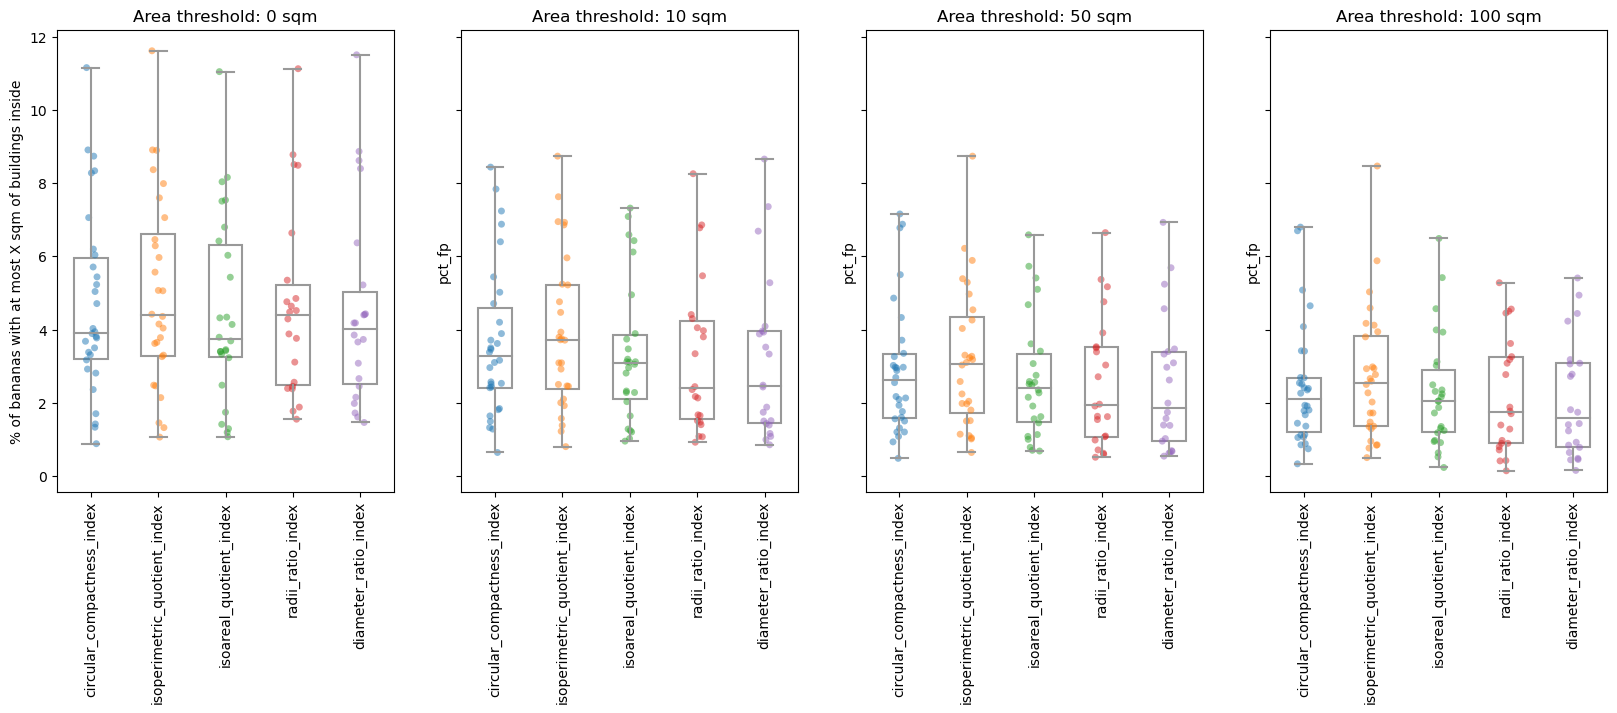

In [72]:
# ### PSEUDO CONFUSION MATRICES ###
# # for an area threshold of X:
# # true positive: is_artifact==True and intersection_area < X
# # true negative: is_artifact==False and intersection_area => X
# # false positive: is_artifact==True and intersection_area => X
# # false negative: is_artifact==False and intersection_area < X
# # note:
# #   true/false positives make sense (bananas != buildings) BUT
# #   true/false negatives make less sense (blocks == buildings is not ALWAYS the case)

# # for each Ti, find % of bananas that contain buildings:


# options = [
#     "circular_compactness_index",
#     "isoperimetric_quotient_index",
#     "isoareal_quotient_index",
#     "radii_ratio_index",
#     "diameter_ratio_index",
# ]

# fig, ax = plt.subplots(1,4, figsize = (20,6), sharey=True)

# for i, area_threshold in enumerate([0,10,50,100]):
#     df_cities, df_options, df_fps = [], [], []
#     for ix, row in tqdm(sample_validation.iterrows(), total=len(sample_validation)):
#         city = row.eFUA_name
#         myid = row.eFUA_ID
#         polygons = geopandas.read_parquet(f"../data/{int(myid)}/polygons/")
#         for option in options:
#             threshold = results[city][option]["threshold"]
#             nr_tot = len(polygons)
#             nr_art = len(polygons[polygons[option]<threshold])
#             if nr_art > 0:
#                 nr_fp = len(polygons[(polygons[option]<threshold) & (polygons["intersection_area"]>area_threshold)])
#                 pct_fp = numpy.round(100*nr_fp/nr_art, 2)
#             else: 
#                 pct_fp = "nan"
#             df_cities.append(city)
#             df_options.append(option)
#             df_fps.append(pct_fp)
#         df = pandas.DataFrame()
#         df["city"] = df_cities
#         df["option"] = df_options
#         df["pct_fp"] = df_fps
#         df.drop(numpy.where(df.pct_fp == "nan")[0], axis = 0, inplace = True)
#         df.drop(df[df["city"]=="Mogadishu"].index, axis = 0, inplace = True)
#     sns.boxplot(
#         ax=ax[i], 
#         data = df,
#         x = "option", 
#         y = "pct_fp",
#         whis=[0, 100], 
#         width=.5,
#         color="white",
#         saturation = 0.2,
#     )
#     sns.stripplot(
#         ax=ax[i],
#         data = df, 
#         x = "option",
#         y = "pct_fp", 
#     #    hue = "pct_fp",
#         dodge = True, 
#         alpha = 0.5, 
#         zorder = 1, 
#     #    legend=False,
#     #    palette=mypalette
#         );

#     ax[i].set_xticklabels(options, rotation=90)
#     ax[i].set_xlabel("")
#     ax[i].set_title(f"Area threshold: {area_threshold} sqm")
# ax[0].set_ylabel("% of bananas with at most X sqm of buildings inside")

# fig.savefig("metrics_validation.png", dpi = 300, bbox_inches = "tight")